In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

In [33]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset


sys.path.insert(0, r'G:\My Drive\DNN')
from collections.abc import Callable
from typing import Literal
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

ImportError: cannot import name 'plot_hist' from 'utils.helper' (G:\My Drive\DNN\utils\helper.py)

In [3]:
print (fn_plot_torch_hist.__doc__)

None


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './torch_models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [9]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [10]:
data_df.isna().sum().sum()

76984

In [11]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [12]:
data_df[data_df['Name']=="S. Chhetri"]

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
8605,8605,190939,S. Chhetri,33,https://cdn.sofifa.org/players/4/19/190939.png,India,https://cdn.sofifa.org/flags/159.png,67,67,NaN,...,67.0,30.0,24.0,44.0,10.0,7.0,11.0,9.0,10.0,NaN


In [13]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [14]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [15]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [16]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [17]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [18]:
# splitting in train ans test datasets
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE)

train_df.shape, test_df.shape

((14517, 34), (3630, 34))

In [19]:
class GlobalScalar:
    _instance =None

    def __init__(self) -> None:
        if GlobalScalar._instance is not None:
            raise Exception ('GlobalScalar class in Singleton')
        
        self.scaler = StandardScaler()

    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance = GlobalScalar()
        return cls._instance

In [20]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cpu device


In [21]:
class FifaDS(Dataset):
    globalScalar = GlobalScalar.get_instance()

    def __init__(self, 
                 dataframe: pd.DataFrame,
                 device: str = device,
                 is_train = True,
                 label_col = None ):
        self.df = dataframe
        self.device = device
        self.is_train = is_train,
        self.scaler = self.globalScalar.scaler
        self.local_col = label_col

        self.labels = self.df[label_col].to_numpy()
        X = self.df.drop(label_col, axis = 1)

        if self.is_train:
             self.features=self.scaler.fit_transform(X)
        else:
            self.features=self.scaler.transform(X)

    def __len__(self):
        return len(self.features)
    
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]

        # Convert to PyTorch tensors
        features = torch.tensor(features,
                                dtype=torch.float32,
                                device=self.device)
        
        label = torch.tensor(label,
                                dtype=torch.int64,
                                device=self.device)
        return features, label

In [22]:
label_col = 'Position'

train_ds = FifaDS(train_df, is_train=True, label_col=label_col)

test_ds = FifaDS(test_df, is_train=False, label_col= label_col)

In [23]:
next(iter(train_ds))

(tensor([ 0.8440,  0.2736, -0.5224,  0.2311,  0.2971, -0.2802, -0.9055, -0.7692,
          0.0364,  0.6969,  0.5615,  0.6422, -0.3119,  0.4269,  0.0910, -0.0058,
         -0.0157, -0.2691,  0.1495, -0.3957, -1.5856,  0.5660, -0.4513,  0.9238,
         -0.5824, -1.3197, -1.4632, -1.5835, -0.3178, -0.5550, -0.3775, -0.2574,
         -0.3184]),
 tensor(3))

In [24]:
next(iter(test_ds))

(tensor([ 1.0411, -1.1245,  0.9070,  0.6866,  1.3589,  1.1846,  1.2589,  0.5459,
          1.2356,  1.4132,  1.2518,  1.7872,  0.2265,  1.7020,  1.1285, -1.8761,
          0.3700, -1.7515,  1.0865, -1.0308, -1.1762,  1.1773,  1.3286,  0.5278,
          0.8080, -1.2249, -1.0037, -0.7347, -0.2595, -0.1450, -0.0179, -0.6065,
         -0.3723]),
 tensor(2))

In [25]:
# input shape
input_shape = train_df.shape[1] - 1
input_shape

33

In [26]:
class Model (nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 16)
        self.activ1 = nn.ReLU()
        self.layer2 = nn.Linear(16,4)

    def forward(self, x):
        x = self.layer1(x) # level 1 aggregation
        x = self.activ1(x)
        x = F.softmax(self.layer2(x), dim=1)
        return x
    
net = Model(input_dim=input_shape).to(device)
print(net)

Model(
  (layer1): Linear(in_features=33, out_features=16, bias=True)
  (activ1): ReLU()
  (layer2): Linear(in_features=16, out_features=4, bias=True)
)


In [27]:
train_loader = DataLoader(train_ds, 
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_loader = DataLoader(test_ds,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

In [28]:
# Initiate the DataLoader
for batch_idx, (data,target) in enumerate(test_loader):
    print(f'Batch {batch_idx + 1}: ', end=" ")
    print("Data: ", data.shape, end=' ')
    print('Target: ', target.shape)


Batch 1:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 2:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 3:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 4:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 5:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 6:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 7:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 8:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 9:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 10:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 11:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 12:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 13:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 14:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 15:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 16:  Data:  torch.Size([32, 

In [29]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), lr=ALPHA)

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:1.0308, test:0.9227 | Acc - train:0.7516, test:0.8281
At epoch 5 | Loss - train:0.8691, test:0.8767 | Acc - train:0.8775, test:0.8656
At epoch 10 | Loss - train:0.8626, test:0.8706 | Acc - train:0.8832, test:0.8722
At epoch 15 | Loss - train:0.8594, test:0.8678 | Acc - train:0.8856, test:0.8719
At epoch 20 | Loss - train:0.8570, test:0.8656 | Acc - train:0.8883, test:0.8774
At epoch 25 | Loss - train:0.8553, test:0.8646 | Acc - train:0.8896, test:0.8763
At epoch 30 | Loss - train:0.8540, test:0.8645 | Acc - train:0.8906, test:0.8758
At epoch 35 | Loss - train:0.8527, test:0.8614 | Acc - train:0.8921, test:0.8846
At epoch 40 | Loss - train:0.8515, test:0.8620 | Acc - train:0.8934, test:0.8780
At epoch 45 | Loss - train:0.8506, test:0.8629 | Acc - train:0.8952, test:0.8788
At epoch 50 | Loss - train:0.8499, test:0.8631 | Acc - train:0.8954, test:0.8774
At epoch 55 | Loss - train:0.8494, test:0.8626 | Acc - train:0.8955, test:0.8782
At epoch 60 | Loss - train:0.8

In [31]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.030792,0.922703,0.751602,0.828099
1,1,0.900244,0.895672,0.850796,0.849311
2,2,0.882757,0.884314,0.864641,0.861983
3,3,0.875604,0.880185,0.871805,0.864738
4,4,0.871774,0.878095,0.873872,0.866116


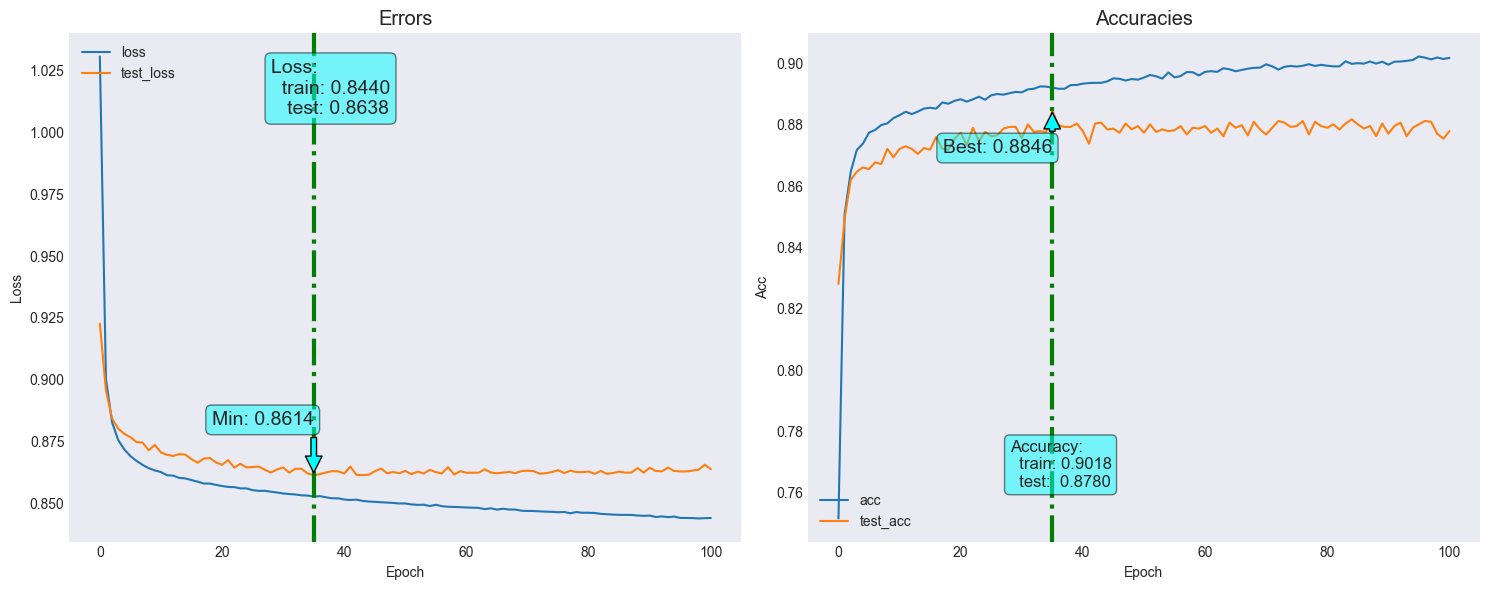

In [34]:
fn_plot_torch_hist(loss_df)

Performance on Train Data

In [48]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [49]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.95      0.94      4693
           2       0.87      0.88      0.87      5470
           3       0.87      0.83      0.85      2734

    accuracy                           0.90     14517
   macro avg       0.92      0.91      0.91     14517
weighted avg       0.90      0.90      0.90     14517



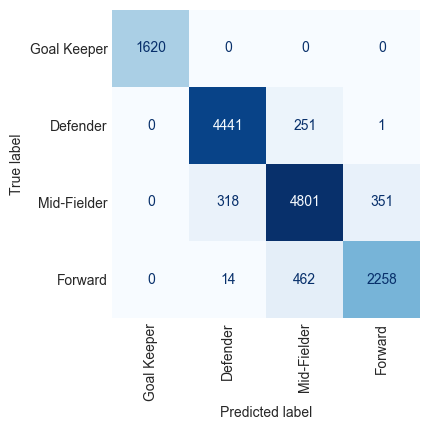

In [51]:
cm  = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
plt.grid(False)
plt.show();

Performance on Testing Data

In [53]:
y_test = []
y_pred = []
for i, data in enumerate(test_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

print(classification_report(y_test, y_pred ))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.93      0.93      1173
           2       0.84      0.85      0.84      1368
           3       0.82      0.77      0.79       684

    accuracy                           0.88      3630
   macro avg       0.89      0.89      0.89      3630
weighted avg       0.88      0.88      0.88      3630



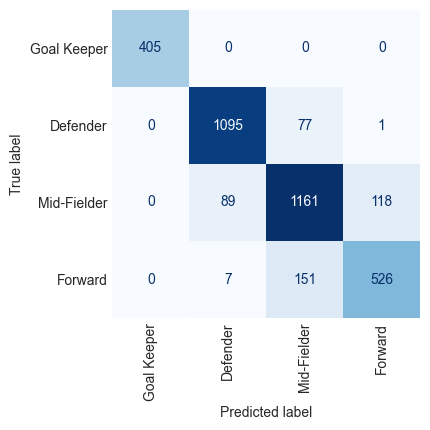

In [54]:
cm  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
plt.grid(False)
plt.show();